In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import requests

import os 

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.lstm.make_dataset import StockReturnsDataset
from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df

import datetime

In [16]:
start_date = datetime.datetime(2021,4,30)
end_date = start_date + datetime.timedelta(600)

In [37]:
# api_key : str = '64d11b117233d0.77790833'
api_key = "demo"
stock = "AAPL"
start_date_utc = start_date.timestamp()
end_date_utc = end_date.timestamp()

url = f'https://eodhistoricaldata.com/api/intraday/{stock}?api_token={api_key}&from={start_date_utc}&to={end_date_utc}&interval={"5m"}&fmt={"json"}'
prices_json = requests.get(url).json()

In [40]:
apple_prices = pd.DataFrame(prices_json)[["close", "datetime"]]

In [48]:
apple_prices["datetime"] = pd.to_datetime(apple_prices["datetime"] ,
                                          utc=True)

In [275]:
apple_prices

,close,datetime
0,132.670104,2021-04-30 13:30:00+00:00
1,132.494995,2021-04-30 13:35:00+00:00
2,132.000000,2021-04-30 13:40:00+00:00
3,132.335006,2021-04-30 13:45:00+00:00
4,132.320007,2021-04-30 13:50:00+00:00
...,...,...
32703,132.274200,2022-12-20 20:40:00+00:00
32704,132.402404,2022-12-20 20:45:00+00:00
32705,132.308807,2022-12-20 20:50:00+00:00
32706,132.289993,2022-12-20 20:55:00+00:00


## News

In [42]:
apple_news = read_company_news_df("apple")

In [66]:
apple_news

,date,title,content,sentiment,sentiment_count
0,2019-01-03 00:09:00+00:00,"Apple, AAPL Investment Losses Alert: Bernstein...","NEW YORK, Jan. 02, 2019 (GLOBE NEWSWIRE) -- ...",neutral,0
1,2019-01-03 17:32:00+00:00,"SHAREHOLDER ALERT: Bronstein, Gewirtz & Grossm...","NEW YORK, Jan. 03, 2019 (GLOBE NEWSWIRE) -- ...",neutral,0
2,2019-02-22 12:40:00+00:00,"Factors of Influence in 2019, Key Indicators a...","NEW YORK, Feb. 22, 2019 (GLOBE NEWSWIRE) -- ...",neutral,0
3,2019-04-01 12:25:00+00:00,"Report: Developing Opportunities within Apple,...","NEW YORK, April 01, 2019 (GLOBE NEWSWIRE) --...",positive,1
4,2019-04-01 12:25:00+00:00,"Report: Developing Opportunities within Apple,...","NEW YORK, April 01, 2019 (GLOBE NEWSWIRE) --...",positive,1
...,...,...,...,...,...
6912,2022-12-30 16:25:17+00:00,"Apple stock a top pick for 2023, Citi analyst ...",Yahoo Finance's Brian Sozzi discusses an analy...,positive,1
6913,2022-12-30 17:31:04+00:00,Apple CEO Cook conveyed app store curb concern...,(Reuters) - Apple Inc Chief Executive Tim Cook...,negative,-1
6914,2022-12-30 17:58:05+00:00,Earnings Outlook for 2023 and Featured Reports...,"Friday, December 30, 2022\n\nThe Zacks Researc...",neutral,0
6915,2022-12-31 10:25:00+00:00,Where Will Apple Stock Be in 1 Year?,Apple's (NASDAQ: AAPL) stock declined nearly 3...,neutral,0


In [297]:
avg_sentiment_quarter = apple_news\
    .groupby(
        by = pd.Grouper(key="date", freq="20min")
    )\
    .mean()\
    .dropna()\
    .reset_index()

/tmp/ipykernel_111052/212464995.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()\


In [298]:
avg_sentiment_quarter.tail(10)

,date,sentiment_count
5428,2022-12-29 18:40:00+00:00,1.0
5429,2022-12-29 19:00:00+00:00,1.0
5430,2022-12-30 09:20:00+00:00,0.0
5431,2022-12-30 14:00:00+00:00,0.0
5432,2022-12-30 15:40:00+00:00,-1.0
5433,2022-12-30 16:20:00+00:00,1.0
5434,2022-12-30 17:20:00+00:00,-1.0
5435,2022-12-30 17:40:00+00:00,0.0
5436,2022-12-31 10:20:00+00:00,0.0
5437,2023-01-01 11:00:00+00:00,1.0


In [299]:
prices_news = pd.merge_asof(
    apple_prices,
    avg_sentiment_quarter,
    left_on="datetime",
    right_on="date",
    allow_exact_matches=True,
    # direction="forward",
    tolerance= datetime.timedelta(2)
)\
    .dropna()

<Axes: >

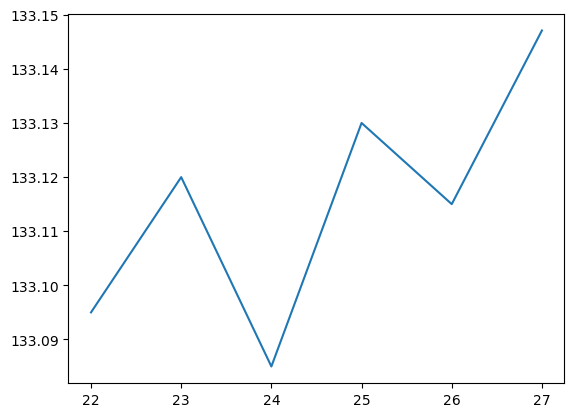

In [303]:
prices_news.loc[22:27].close.plot()

In [300]:
prices_news.query('sentiment_count != 0 & sentiment_count != -1 & sentiment_count != 1')

,close,datetime,date,sentiment_count
2,132.000000,2021-04-30 13:40:00+00:00,2021-04-30 13:40:00+00:00,-0.50
3,132.335006,2021-04-30 13:45:00+00:00,2021-04-30 13:40:00+00:00,-0.50
4,132.320007,2021-04-30 13:50:00+00:00,2021-04-30 13:40:00+00:00,-0.50
5,132.759994,2021-04-30 13:55:00+00:00,2021-04-30 13:40:00+00:00,-0.50
80,132.889999,2021-05-03 13:40:00+00:00,2021-05-03 13:40:00+00:00,0.50
...,...,...,...,...
31971,140.865005,2022-12-07 18:55:00+00:00,2022-12-07 18:00:00+00:00,0.25
32244,148.630004,2022-12-13 15:20:00+00:00,2022-12-13 15:20:00+00:00,0.50
32245,148.089996,2022-12-13 15:25:00+00:00,2022-12-13 15:20:00+00:00,0.50
32246,148.210006,2022-12-13 15:30:00+00:00,2022-12-13 15:20:00+00:00,0.50


In [304]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [305]:
prices_news["scaled_prices"]= scaler.fit_transform(prices_news[["close"]])

In [306]:
prices_news = prices_news.set_index("datetime")

In [250]:
avg_sentiment_periods = prices_news["sentiment_count"]\
    .rolling(10)\
    .mean()

std_sentiment_periods = prices_news["sentiment_count"]\
    .rolling(10)\
    .std()

In [307]:
buy_signal = (prices_news["sentiment_count"]> .5) #& (prices_news["sentiment_count"] < .75)
# buy_signal = mean_sentiment_periods > .25 

# buy_signal = ((prices_news["sentiment_count"] - avg_sentiment_periods)/std_sentiment_periods)> 1.5

# buy_signal = avg_sentiment_periods > 0.5

In [308]:
sell_signal = (prices_news["sentiment_count"] < -.5) #& (prices_news["sentiment_count"] > -.75)
# sell_signal = mean_sentiment_periods < -.25

# sell_signal = ((prices_news["sentiment_count"] - avg_sentiment_periods)/std_sentiment_periods)< -1.5

# sell_signal = avg_sentiment_periods < -0.5

In [309]:
prices_news

,close,date,sentiment_count,scaled_prices
datetime,,,,
2021-04-30 13:30:00+00:00,132.670104,2021-04-30 13:00:00+00:00,-1.0,-0.657902
2021-04-30 13:35:00+00:00,132.494995,2021-04-30 13:00:00+00:00,-1.0,-0.663690
2021-04-30 13:40:00+00:00,132.000000,2021-04-30 13:40:00+00:00,-0.5,-0.680051
2021-04-30 13:45:00+00:00,132.335006,2021-04-30 13:40:00+00:00,-0.5,-0.668978
2021-04-30 13:50:00+00:00,132.320007,2021-04-30 13:40:00+00:00,-0.5,-0.669474
...,...,...,...,...
2022-12-20 20:40:00+00:00,132.274200,2022-12-20 14:40:00+00:00,0.0,-0.670988
2022-12-20 20:45:00+00:00,132.402404,2022-12-20 14:40:00+00:00,0.0,-0.666750
2022-12-20 20:50:00+00:00,132.308807,2022-12-20 14:40:00+00:00,0.0,-0.669844


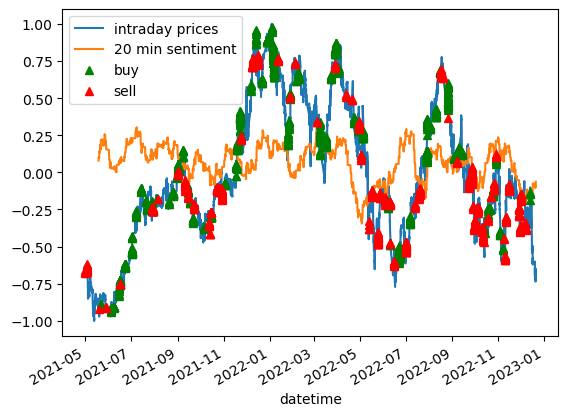

In [310]:
prices_news["scaled_prices"]\
    .plot(
        label = "intraday prices"
    )

prices_news["sentiment_count"]\
    .rolling(1000)\
    .mean()\
    .plot(
        label = "20 min sentiment"
    )

prices_news["scaled_prices"][buy_signal]\
    .plot(
        color = "green",
        linestyle = "None",
        marker = "^",
        label = "buy"
    )

prices_news["scaled_prices"][sell_signal]\
    .plot(
        color = "red",
        linestyle = "None",
        marker = "^",
        label = "sell"
    )

plt.legend()

In [322]:
prices_news["position"] = np.nan

In [323]:
prices_news.loc[buy_signal, "position"] = 1

prices_news.loc[sell_signal, "position"] = -1

In [321]:
(prices_news["position"]== 0 ).sum()

30135

In [324]:
prices_news

,close,date,sentiment_count,scaled_prices,position
datetime,,,,,
2021-04-30 13:30:00+00:00,132.670104,2021-04-30 13:00:00+00:00,-1.0,-0.657902,NaN
2021-04-30 13:35:00+00:00,132.494995,2021-04-30 13:00:00+00:00,-1.0,-0.663690,NaN
2021-04-30 13:40:00+00:00,132.000000,2021-04-30 13:40:00+00:00,-0.5,-0.680051,-1.0
2021-04-30 13:45:00+00:00,132.335006,2021-04-30 13:40:00+00:00,-0.5,-0.668978,-1.0
2021-04-30 13:50:00+00:00,132.320007,2021-04-30 13:40:00+00:00,-0.5,-0.669474,-1.0
...,...,...,...,...,...
2022-12-20 20:40:00+00:00,132.274200,2022-12-20 14:40:00+00:00,0.0,-0.670988,NaN
2022-12-20 20:45:00+00:00,132.402404,2022-12-20 14:40:00+00:00,0.0,-0.666750,NaN
2022-12-20 20:50:00+00:00,132.308807,2022-12-20 14:40:00+00:00,0.0,-0.669844,NaN


In [333]:
pnl = pd.Series(
    0,
    index = prices_news.index
)

last_buy_price = np.nan
cash = 0
position = 0 

for date, row in tqdm(prices_news.iterrows()):
    first_trade = np.isnan(last_buy_price) and not np.isnan(row["position"])
    has_position = not np.isnan(last_buy_price)
    changing_position = has_position and row["position"] != position
    holding_position = has_position and row["position"] == position

    if (first_trade):
        last_buy_price = row["close"]
        position = row["position"]

    if (changing_position):
        cash += (row["close"] / last_buy_price - 1 )*position

        if np.isnan(row["position"]):
            position = 0
        
        last_buy_price = np.nan
        # last_buy_price = np.nan
        # last_buy_price = row["close"]
        # position = row["position"]

    if holding_position:
        pnl.loc[date] = (row["close"]- last_buy_price)/last_buy_price * position + cash

    else:
        pnl.loc[date] = cash

# if row["position"] != 0:
#     cash += (row["real_price"]- last_buy_price)/last_buy_price * position

    # pnl.loc[date] = cash

32698it [00:05, 6334.03it/s]


<Axes: xlabel='datetime'>

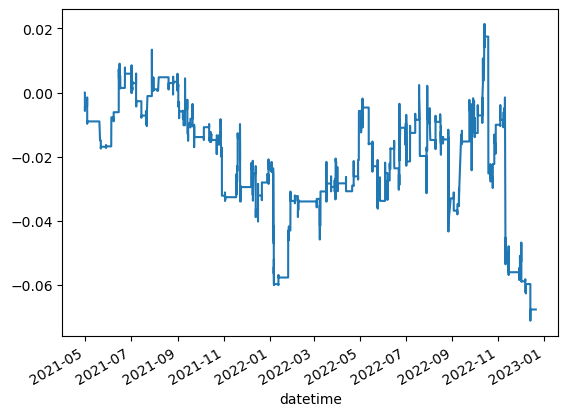

In [334]:
pnl.plot()